In [1]:
import torch
import numpy as np
import pandas as pd
from tqdm import tqdm
import io
from PIL import Image
import pyarrow as pa
from vilt.config import ex
from vilt.modules import ViLTransformerSS

# from vilt.modules.objectives import cost_matrix_cosine, ipot
from vilt.transforms import pixelbert_transform
from vilt.datamodules.datamodule_base import get_pretrained_tokenizer

In [5]:
df = pa.ipc.RecordBatchFileReader(
    pa.memory_map(f"dataset_50/cosmos_test.arrow", "r")
).read_all().to_pandas()

In [2]:
_config = {'exp_name': 'vilt', 'seed': 0, 'datasets': ['coco', 'vg', 'sbu', 'gcc'], 'loss_names': {'itm': 1, 'mlm': 1, 'mpp': 0, 'vqa': 0, 'nlvr2': 0, 'irtr': 0, 'cosmos': 0}, 'batch_size': 4096, 'train_transform_keys': ['pixelbert'], 'val_transform_keys': ['pixelbert'], 'image_size': 384, 'max_image_len': -1, 'patch_size': 32, 'draw_false_image': 1, 'image_only': False, 'vqav2_label_size': 3129, 'max_text_len': 40, 'tokenizer': 'bert-base-uncased', 'vocab_size': 30522, 'whole_word_masking': False, 'mlm_prob': 0.15, 'draw_false_text': 0, 'vit': 'vit_base_patch32_384', 'hidden_size': 768, 'num_heads': 12, 'num_layers': 12, 'mlp_ratio': 4, 'drop_rate': 0.1, 'optim_type': 'adamw', 'learning_rate': 0.0001, 'weight_decay': 0.01, 'decay_power': 1, 'max_epoch': 100, 'max_steps': 25000, 'warmup_steps': 2500, 'end_lr': 0, 'lr_mult': 1, 'get_recall_metric': False, 'resume_from': None, 'fast_dev_run': False, 'val_check_interval': 1.0, 'test_only': False, 'data_root': '', 'log_dir': 'result', 'per_gpu_batchsize': 0, 'num_gpus': 1, 'num_nodes': 1, 
    'load_path': 'result/data_neg_seed0_from_vilt_200k_mlm_itm/version_1/checkpoints/epoch=0-step=8045.ckpt', 'num_workers': 8, 'precision': 16}

In [3]:
loss_names = {
        "itm": 0,
        "mlm": 0,
        "mpp": 0,
        "vqa": 0,
        "imgcls": 0,
        "nlvr2": 0,
        "irtr": 0,
        "arc": 0,
        "cosmos":1
    }
tokenizer = get_pretrained_tokenizer(_config["tokenizer"])

_config.update(
    {
        "loss_names": loss_names,
    }
)

In [4]:
model = ViLTransformerSS(_config)
model.setup("test")
model.eval();

In [6]:
device = "cuda:1" if _config["num_gpus"] > 0 else "cpu"
model.to(device);

In [7]:
from sentence_transformers import SentenceTransformer, util
bert = SentenceTransformer('bert-base-uncased')

Some weights of the model checkpoint at /root/.cache/torch/sentence_transformers/bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [36]:
from torch import nn
def infer(image,text,text2):
    img = pixelbert_transform(size=384)(image)
    img = img.unsqueeze(0).to(device)
    batch = {"text": [text], "image": [img], "text2": [text2]}
    with torch.no_grad():
        encoded = tokenizer(batch["text"],
        padding="max_length",
        truncation=True,
        max_length=40,
        return_special_tokens_mask=True)
        batch["text_ids"] = torch.tensor(encoded["input_ids"]).to(device)
        batch["text_labels"] = torch.tensor(encoded["input_ids"]).to(device)
        batch["text_masks"] = torch.tensor(encoded["attention_mask"]).to(device)

        encoded = tokenizer(batch["text2"],
        padding="max_length",
        truncation=True,
        max_length=40,
        return_special_tokens_mask=True)
        batch["text2_ids"] = torch.tensor(encoded["input_ids"]).to(device)
        batch["text2_labels"] = torch.tensor(encoded["input_ids"]).to(device)
        batch["text2_masks"] = torch.tensor(encoded["attention_mask"]).to(device)

        infer1 = model.infer(batch, text_token_type_idx=1)
        infer2 = model.infer(batch, text_token_type_idx=2)
        cls_feats = torch.cat([infer1["cls_feats"], infer2["cls_feats"]], dim=-1)

        cosmos_logits = model.nlvr2_classifier(cls_feats)
    # encoded = encoded["input_ids"][0][1:-1]
    # inferred_token = [tokenizer.decode(encoded)]
    # return infer1,inferred_token
    sm = nn.Softmax(dim=-1)
    return  sm(cosmos_logits).tolist()[0][1]
    # return cosmos_logits.argmax().item()

In [9]:
def get_raw_image(img_byte):
    image_bytes = io.BytesIO(img_byte)
    image_bytes.seek(0)
    return Image.open(image_bytes).convert("RGB")

In [ ]:
df['emp_1'] = df['caption_1'].apply(lambda x: bert.encode(x[0],convert_to_tensor=True))
df['emp_2'] = df['caption_2'].apply(lambda x: bert.encode(x[0],convert_to_tensor=True))

In [17]:
df['score'] = df.apply(lambda x: util.cos_sim(x.emp_1, x.emp_2)[0][0], axis=1)

In [18]:
df['label'] = df['label'].apply(lambda x:x[0])

In [37]:
infer(get_raw_image(r['image']), r['caption_1'][0], r['caption_2'][0])

0.8626351356506348

In [40]:
result = pd.DataFrame({},columns=['ooc_score','label','cap1','cap2'])
for i in tqdm(np.arange(len(df))):
    r = df.iloc[i]
    ans = r['label']
    # if r['nli']=='entail':
    #     result.loc[len(result)] = [0, ans,r['caption_1'][0],r['caption_2'][0]]
    #     continue
    # if r['score']>0.85:
    #     result.loc[len(result)] = [0, ans,r['caption_1'][0],r['caption_2'][0]]
    #     continue
    pred = infer(get_raw_image(r['image']), r['caption_1'][0], r['caption_2'][0])
    # s = util.cos_sim(model2.encode(r['caption_1'][0]),(model2.encode(r['caption_2'][0])))
    # pred = pred == True
    
    result.loc[len(result)] = [pred, ans,r['caption_1'][0],r['caption_2'][0]]

100%|██████████| 1700/1700 [01:13<00:00, 23.25it/s]


In [41]:
result['ooc_score'].describe()

count    1700.000000
mean        0.476784
std         0.358492
min         0.005042
25%         0.110517
50%         0.437559
75%         0.834824
max         0.999769
Name: ooc_score, dtype: float64

In [48]:
result['predict1']=result['ooc_score']>0.5

In [50]:
result['ooc_score'].to_csv('vilt.csv',index=False)

In [49]:
confusion_matrix = pd.crosstab(result['predict1'], result['label'], rownames=['Predicted'], colnames=['Actual'])
print (confusion_matrix)
(confusion_matrix[0][0]+confusion_matrix[1][1])/1700


Actual     False  True 
Predicted              
False        617    292
True         233    558


0.6911764705882353

In [20]:
result

0.6911764705882353

In [12]:
(617+558)/1700

0.6911764705882353

In [17]:
confusion_matrix = pd.crosstab(result['predict'], result['label'], rownames=['Predicted'], colnames=['Actual'])
print (confusion_matrix)

Actual     False  True 
Predicted              
False        812    504
True          38    346


In [35]:
confusion_matrix = pd.crosstab(result['predict'], result['label'], rownames=['Predicted'], colnames=['Actual'])
print (confusion_matrix)

Actual     False  True 
Predicted              
False        651    409
True         199    441


In [36]:
(651+ 441)/1700

0.6423529411764706

In [18]:
(812 + 346) / (1700)

0.6811764705882353

In [41]:
df['score'] = df['score'].apply(lambda x:x.cpu().detach().numpy())

In [54]:
result

,predict1,label,cap1,cap2
0,0,False,"PERSON at his announcement in GPE, GPE, on DAT...","PERSON at his announcement in GPE, GPE, on DATE."
1,0,False,Supporters of GPE's ruling ORG party come out ...,A person sits on a truck as supporters of the ...
2,True,True,CARDINAL dead people turned up on the state’s ...,These social media posts did not link to a rec...
3,True,True,"Actor, musician, director and devoted follower...",A shocking report about the former child actor...
4,False,False,Men from the LOC tribe perform a traditional j...,"And on DATE in GPE's Narok county, young PERSO..."
...,...,...,...,...
1695,True,True,President PERSON trademarked the name 'WORK_OF...,There was no truth that PERSON family MONEY wi...
1696,True,True,A photograph shows a soldier carrying a donkey...,Coronavirus meme featuring “EVENT donkey” is n...
1697,True,False,Homeless people living on streets in GPE,ORG in GPE
1698,False,False,The castle's esplanade was a perfect spot for ...,Picture shows an ORG skier


<AxesSubplot:>

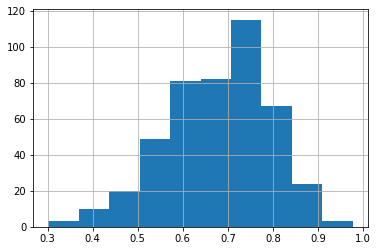

In [45]:
df[(df['nli']=='contradiction')]['score'].hist()

In [53]:
df[(df['score']>0.9)]['label'].value_counts()

False    63
True      7
Name: label, dtype: int64

In [64]:
wrong = df[(result['predict'] != result ['label']) & (result['predict']==True)]
wrong[['caption_1','caption_2']]
# correct_true['caption_1'].iloc[0],correct_true['caption_2'].iloc[0]

,caption_1,caption_2
9,[A man brushes the mouth of a sarcophagus.],"[CARDINAL statues of ancient deities and funerary masks were also discovered at the site, many of which still with their original colours and designs preserved]"
21,"[A tribute to Captain Sir PERSON lights up ORG, GPE. The DATE, who raised almost ORGm for ORG charities by walking laps of his garden, died with coronavirus.]",[A woman plays the violin in ORG during a tribute to Captain Sir PERSON on 2 DATE]
48,"[The PERSON and ORG, ORG, by PERSON, from the GPE]",[A sacred cow in a street in GPE]
52,"[Lex Scott Davis and PERSON in ""WORK_OF_ART.""]","[PERSON (right) plays a suave drug dealer named Priest and PERSON is GPE in GPE, Director X’s blinged-out redo of the DATE blaxploitation classic.]"
64,"[NORP paramilitary troops in GPE in GPE DATE. PERCENT of the army's equipment is so old that it is officially considered ""vintage.""]","[LOC braces for worst as shelling, gunbattles escalate]"
...,...,...
1654,"[Mr. PERSON won the fiercely contested race by CARDINAL votes, out of CARDINAL.]","[PERSON, the NORP candidate for ORG, is accompanied by his wife, PERSON, at an LOC gathering of his supporters in GPE, GPE, on DATE.]"
1667,[Heavy snowfall had be be cleared on FAC during one of the DATE in the early 1900s],"[CARDINAL - Duke Street, Barrow-in-Furness DATE-CARDINAL ORG]"
1678,[A photographer's self portrait with her mother is one of many works featured at ORG ORDINAL DATE NORP Foto Festival.],"[CARDINAL women embrace, wearing face masks]"
1687,[PERSON taking a photo],[A child holds a camera next to a destroyed bus]


In [1]:
get_raw_image(df['image'].iloc[1687])

NameError: name 'get_raw_image' is not defined